In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os; os.environ['OMP_NUM_THREADS'] = '1'
from contextlib import contextmanager
from functools import partial
from operator import itemgetter
from multiprocessing.pool import ThreadPool
import time
from typing import List, Dict

import keras as ks
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
def make_confusion_matrix(y_pred,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    cm=metrics.confusion_matrix( y_actual, y_pred, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [6]:
import nltk
nltk.download('vader_lexicon')
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [7]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    vocab=5000
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [9]:
def generate_embedding_matrix(token):
    embedding_path='/content/gdrive/MyDrive/crawl-300d-2M.vec'
    embedding_size=300
    vocab_size=5000
    embedding_index={}
    with open(embedding_path, 'r') as f:
         for line in f:
             values = line.rstrip().rsplit(' ')
             word = values[0]
             coefs = np.asarray(values[1:], dtype='float32')
             embedding_index[word] = coefs
    num_words = len(token.word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_size))
    for word, i in token.word_index.items():
       embedding_vector = embedding_index.get(word)
       if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [10]:
from tensorflow.keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [11]:
from sklearn.preprocessing import Normalizer
def Normalizer_data(train,test):
  trans = Normalizer()
  X_train=trans.fit_transform(train.reshape(-1,1))  
  X_test=trans.transform(test.reshape(-1,1))
  return X_train,X_test

100%|██████████| 1010826/1010826 [04:51<00:00, 3463.05it/s]


1___
(707578, 200) (303248, 200)
2___
(707578, 200) (303248, 200)
(137185, 300) (189737, 300)
3____
(707578, 9) (303248, 9)
4____
Model training start
Valid Accuracy:- 0.7435729172162718
Total time:- 869.4467616081238


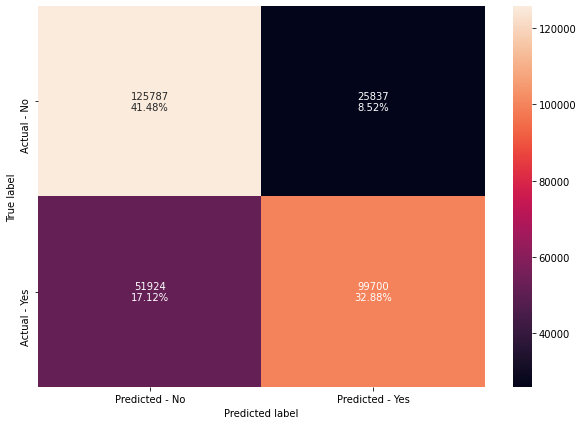

In [12]:
import time
import os
import datetime
from tensorflow.keras.callbacks import * 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
def LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model
def preproces(data: pd.DataFrame) -> pd.DataFrame:
    data['comment'] = data['comment'].fillna('No Comment')
    data['comment']=preprocess(data['comment'],stopword=False)
    data['parent_comment']=preprocess(data['parent_comment'],stopword=False)
    data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)
    data['com_len']=data['comment'].apply(lambda x:len(x.split()))
    data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))
    return data

def fit_predict(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm,X_train,X_test,y_train,y_test) -> np.ndarray:
    model4=LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
    filepath="/content/gdrive/MyDrive/weights_4.best.hdf1"
    model4.load_weights(filepath)
    return model4.predict(X_test)

def main(): 
    t0 = time.time()
    train = pd.read_csv('/content/gdrive/MyDrive/train-balanced-sarcasm.csv')
    data=preproces(train)
    labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
    X=data.drop(['label','date','created_utc'],axis=1)
    X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)
    print("1___")
    comm_len=200
    train_com_pad,test_com_pad,token_comm= text_padding(X_train['comment'].values,X_test['comment'].values,comm_len)
    print(train_com_pad.shape,test_com_pad.shape)
    par_comm_len=200
    print('2___')
    train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)
    print(train_par_com_pad.shape,test_par_com_pad.shape)
    embedding_comm = generate_embedding_matrix(token_comm)
    embedding_P_comm = generate_embedding_matrix(token_par)
    print(embedding_comm.shape,embedding_P_comm.shape)
    print('3____')
    X_train_score,X_test_score=Normalizer_data(X_train['score'].values,X_test['score'].values)
    X_train_ups,X_test_ups=Normalizer_data(X_train['ups'].values,X_test['ups'].values)
    X_train_downs,X_test_downs=Normalizer_data(X_train['downs'].values,X_test['downs'].values)
    X_train_comp,X_test_comp=Normalizer_data(X_train['compound'].values,X_test['compound'].values)
    X_train_neg,X_test_neg=Normalizer_data(X_train['negative'].values,X_test['negative'].values)
    X_train_pos,X_test_pos=Normalizer_data(X_train['positive'].values,X_test['positive'].values)
    X_train_neu,X_test_neu=Normalizer_data(X_train['neutral'].values,X_test['neutral'].values)
    X_train_com_len,X_test_com_len=Normalizer_data(X_train['com_len'].values,X_test['com_len'].values)
    X_train_parent_com_len,X_test_parent_com_len=Normalizer_data(X_train['parent_com_len'].values,X_test['parent_com_len'].values)
    numerical_train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
    numerical_test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)
    print(numerical_train.shape,numerical_test.shape)
    print('4____')
    X_train=[train_com_pad,train_par_com_pad,numerical_train]
    X_test=[test_com_pad,test_par_com_pad,numerical_test]
    print('Model training start')
    del train
    y_pred=fit_predict(comm_len,token_comm,par_comm_len,token_par,embedding_comm,embedding_P_comm,X_train,X_test,y_train,y_test)
    y_test_=np.argmax(y_test, axis=-1)
    y_pred_=np.argmax(y_pred, axis=-1)
    print('Valid Accuracy:-',accuracy_score(y_test_,y_pred_))
    make_confusion_matrix(y_pred_,y_test_)
    t1 = time.time()
    print('Total time:-',t1-t0)
if __name__ == '__main__':
    main()